In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

#TensorFlow Warning Suppression
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
df = pd.read_csv("TSLA.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


To better analyze the data, we need to obtain information about the dataset.

In [6]:
df.shape

(2416, 7)

In [7]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [8]:
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


In [9]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

After examining the data, the Date variable, although it indicates a date, is of type object. We need to convert it into a date variable that Python can understand. Also, the variable we are interested in here is the closing price. We will perform a prediction based on daily closing prices, so we will focus on the Date and Close variables.

In [10]:
df["Date"] = pd.to_datetime(df["Date"])

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [12]:
tesla_df = df[["Date", "Close"]]

In [13]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [14]:
print("Minimum Tarih:", tesla_df["Date"].min())
print("Maksimum Tarih:", tesla_df["Date"].max())

Minimum Tarih: 2010-06-29 00:00:00
Maksimum Tarih: 2020-02-03 00:00:00


We need to set the Date as the index so that we have only one time-focused variable (Close).

In [15]:
tesla_df.index = tesla_df["Date"]

In [16]:
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


The Date is present both as an index and as a column. We need to delete the column.

In [17]:
tesla_df.drop("Date", axis=1, inplace=True)

In [18]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


Since it might be needed in the future, let's make a copy of tesla_df.

In [19]:
result_df = tesla_df.copy()

Data is ready. Let's create a visualization.

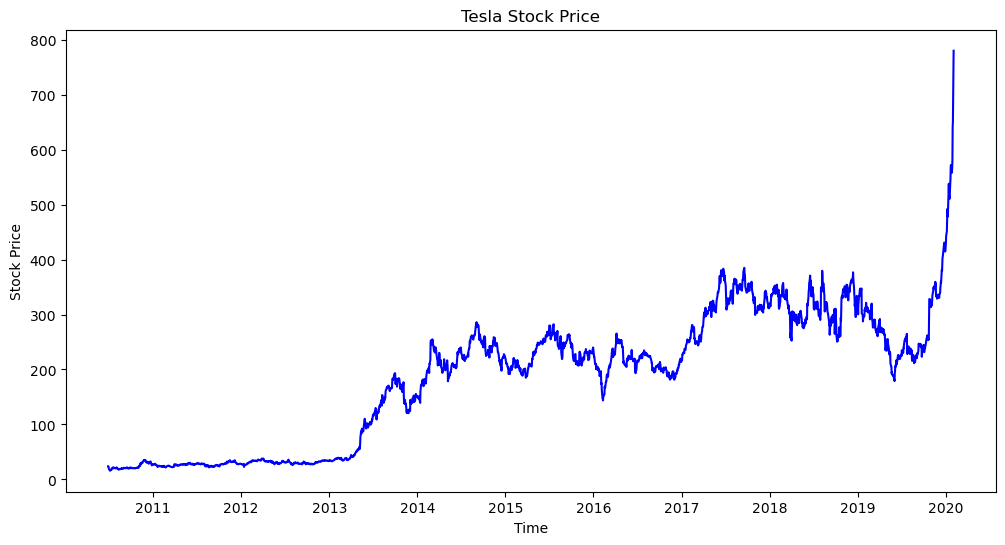

In [20]:
plt.figure(figsize=(12,6))
plt.plot(tesla_df['Close'], color='blue')
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.show()

To model the dataset using LSTM, we first need to convert this data into a numpy array.

In [21]:
tesla_df = tesla_df.values

In [22]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

The next step is to set the data type to float32. The float32 data type is commonly used in neural networks.

In [23]:
tesla_df = tesla_df.astype('float32')

In [24]:
#train test distinction
def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1 - test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

The reason we use the train_test_split function from the sklearn library is that it randomly splits the data. In problems related to time series, a random distribution disregards the time context.

In [25]:
train, test, pos = split_data(tesla_df, 0.20)

In [26]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


Let's scale the data to reduce optimization time.

In [27]:
scaler_train = MinMaxScaler(feature_range=(0, 1))

In [28]:
train = scaler_train.fit_transform(train)

In [29]:
scaler_test = MinMaxScaler(feature_range=(0, 1))

In [30]:
test = scaler_test.fit_transform(test)

In [31]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [32]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

We need to derive some features. In time series, the value at time t is most influenced by the value at t−1 (i.e., by the preceding values). Since we will be using an LSTM model, we will perform a similar process to reflect this characteristic in the model.

In [33]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i, 0])

    return np.array(X), np.array(Y)

In [34]:
lookback = 20    # set the period to 20.

In [35]:
# train data set
X_train, y_train = create_features(train, lookback)
# test data set
X_test, y_test = create_features(test, lookback)

In [36]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [37]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [38]:
y_train[0:5]

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

We need to convert the data into a suitable format for the LSTM (it expects three-dimensional data). In this case, the dataset needs to be transformed into a three-dimensional format.

In [39]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [40]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [41]:
#modeling
model = Sequential()
model.add(LSTM(units=50,
                activation='relu',
                input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))   #output layer

If this were a classification problem with two or more classes, the output layer would have included as many neurons as there are classes.

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Setting Optimization and Evaluation Metrics
model.compile(loss='mean_squared_error', optimizer='adam')

In [45]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
    ModelCheckpoint(filepath='mymodel.keras', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

In [46]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    shuffle=False)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.0039     
Epoch 1: val_loss improved from inf to 0.00342, saving model to mymodel.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 2/100
 1/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051
Epoch 2: val_loss improved from 0.00342 to 0.00315, saving model to mymodel.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.0044 - val_loss: 0.0032
Epoch 3/100
 1/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025
Epoch 3: val_loss improved from 0.00315 to 0.00272, saving model to mymodel.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.0022
Epoch 4: val_loss improved from 0.00272 to 0.00255, saving model to mymodel.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 5/100
 1/96 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9867e-04
Epoch 5: val_loss did not improve 

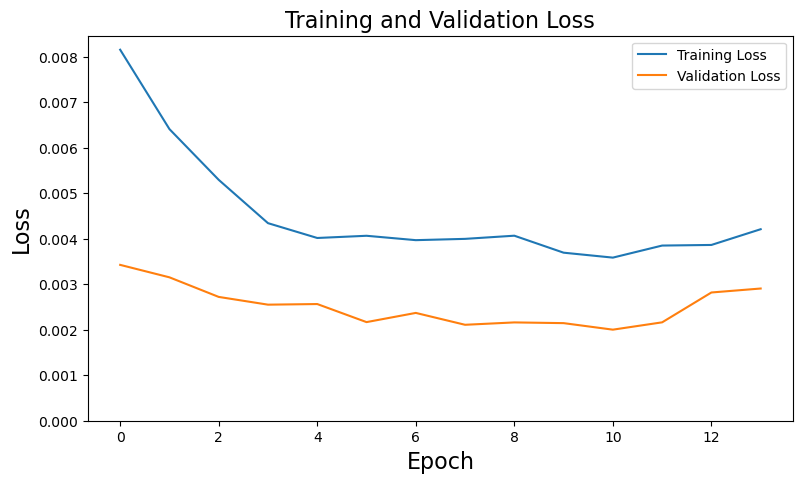

In [47]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

In [48]:
#evaluation
loss = model.evaluate(X_test, y_test, batch_size=20)
print("\nTest loss: %.1f%%" % (100.0 * loss))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.0027

Test loss: 0.3%


In [49]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


We are observing the standardized form of the MSE values of the data. Let's convert the values back to their original form to better understand the loss.

In [50]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [51]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [52]:
# RMSE value for the train dataset
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [53]:
# RMSE value for the test dataset
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [54]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 15.208868026733398
Test RMSE: 32.39301681518555


In [55]:
train_prediction_df = result_df[lookback:pos]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,36.388767
2010-07-29,20.350000,36.486057
2010-07-30,19.940001,36.566582
2010-08-02,20.920000,36.620338
2010-08-03,21.950001,36.599621


In [56]:
test_prediction_df = result_df[pos+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,319.180878
2018-04-04,286.940002,316.645752
2018-04-05,305.720001,313.570557
2018-04-06,299.299988,314.910187
2018-04-09,289.660004,315.963684


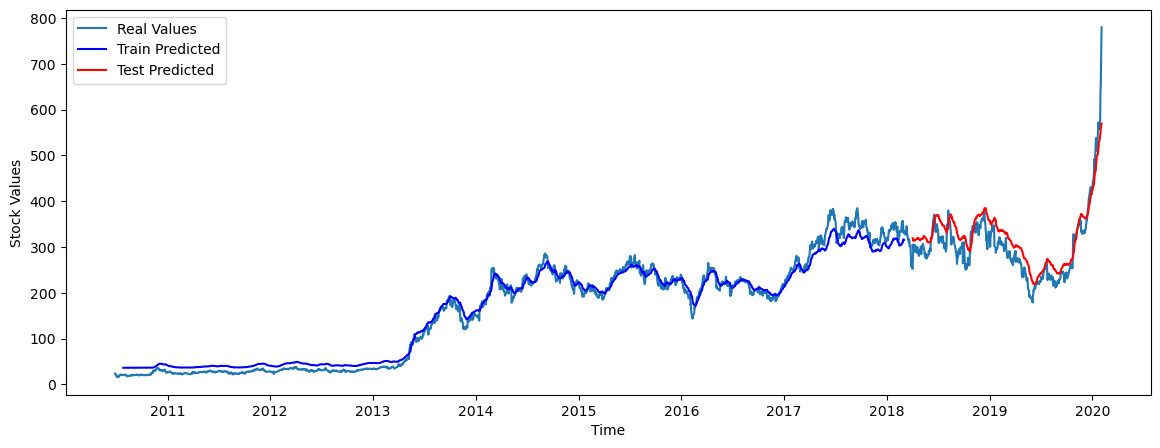

In [57]:
# Visualization of Train and Test Predictions Separately
plt.figure(figsize=(14, 5))
plt.plot(result_df, label='Real Values')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted')
plt.plot(test_prediction_df["Predicted"], color='red', label='Test Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()